### Import Libraries

In [79]:
import numpy as np
import pandas as pd
import sklearn

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import RFE

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV


In [2]:
import requests
import bs4
import re
from selenium import webdriver
import time
from random import randint
from time import sleep
import sqlalchemy
import random
import copy

#### Settings

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

### General Functions

#### Clean \N values

In [6]:
def clean_N(df, col, replace, type):
    df[col] = df[col].replace('\\N', replace)
    df[col] = df[col].astype(type)
    return df[col].value_counts().sort_index()

#### Plot heatmap

In [56]:
def plot_heatmap(df):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(30, 20))
    sns.heatmap(corr, mask=mask, cmap='cividis', vmax=.8, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={"size": 50 / np.sqrt(len(corr))})
    plt.title('Correlation Heatmap')
    plt.show()

#### Split X_y

In [46]:
def split_X_y(df, target_col):
    # Split dataframe into X and y
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    return X, y

#### Split data 20%

In [47]:
def split_data(X, y, test_size=0.2, random_state=42):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

#### Plot feature importances

In [49]:
def plot_feature_importances(model, X_train):
    # Get absolute value of coefficients
    coefs = np.abs(model.coef_)
    
    # Normalize coefficients
    coefs /= np.sum(coefs)
    
    # Sort coefficients by importance
    sorted_idx = np.argsort(coefs)
    
    # Get feature names
    feature_names = X_train.columns.values
    
    plt.figure(figsize=(8, 5))
    plt.barh(range(len(sorted_idx)), coefs[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
    # set the tick label font size and other parameters
    plt.tick_params(axis='both', which='major', labelsize=6, length=6, width=2, direction='out', pad=8)

    plt.xlabel('Normalized Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.show()

#### Models evaluation

In [51]:
def model_evaluation(X_train, X_test, y_train, y_test, k_fold, model_pipeline, model_names):
    i = 0
    
    for model in model_pipeline:

        model_f = model.fit(X_train, y_train)
        y_pred_test = model_f.predict(X_test)
        y_pred_train= model_f.predict(X_train)

        ave_of_cval_scores = cross_val_score(model, X_train, y_train, cv=k_fold).mean()
        std_of_cval_scores = cross_val_score(model, X_train, y_train, cv=k_fold).std()

        performance_df = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall', 'Ave of Scores', 'Std of Scores'],
                            'Train': [accuracy_score(y_train, y_pred_train),
                                        precision_score(y_train, y_pred_train),
                                        recall_score(y_train, y_pred_train)," "," "],
                            'Test': [accuracy_score(y_test, y_pred_test),
                                    precision_score(y_test, y_pred_test),
                                    recall_score(y_test, y_pred_test)," "," "],
                            'Cross Validation':[' ',' ',' ', ave_of_cval_scores, std_of_cval_scores]
                                    })
        
        pd.options.display.float_format = '{:.2f}'.format
        heads = [[model_names[i],model_names[i],model_names[i],model_names[i]],[' ','Train', 'Test', 'Cross Val']]
        performance_df.columns = heads

        if i > len(model_pipeline)-1:
            continue
        else:
            i += 1
        
        display(performance_df)
    return

#### Plot confusion matrix

In [124]:
def plot_confusion_matrix_2(X_train, X_test, y_train, y_test, model_pipeline, model_names):
    i = 0
    for model in model_pipeline:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
        
        plot_confusion_matrix(model,X_train ,y_train ,ax1)
        ax1.set_title(model_names[i] + "\n" '- Train Set')

        plot_confusion_matrix(model,X_test,y_test,ax2)
        ax2.set_title(model_names[i] +"\n" + '- Test Set')

        if i > len(model_pipeline)-1:
            continue
        else:
            i += 1

### Web Scraping Prep

#### Creating tables of ratings (by gender by age)

In [130]:
first_row = ['tt0000008', 5.4, 2097.0, 5.3, 1458.0, 5.6, 161.0, 6.0, 1.0, 0.0, 0.0, 6.0, 1.0, 5.5, 271.0, 5.5, 235.0, 5.5, 31.0, 5.2, 951.0, 5.2, 846.0, 5.5, 92.0, 5.5, 361.0, 5.5, 321.0, 6.0, 34.0] #len = 31
table_headers = ['tconst', 'all_all_ratings', 'all_all_v_counts', 'all_males_ratings', 'all_males_v_counts', 'all_females_ratings', 'all_females_v_counts', 'under_18_all_ratings', 'under_18_all_v_counts', 'under_18_males_ratings', 'under_18_males_v_counts', 'under_18_females_ratings', 'under_18_females_v_counts', 'f18_29_all_ratings', 'f18_29_all_v_counts', 'f18_29_males_ratings', 'f18_29_males_v_counts', 'f18_29_females_ratings', 'f18_29_females_v_counts', 'f30_44_all_ratings', 'f30_44_all_v_counts', 'f30_44_males_ratings', 'f30_44_males_v_counts', 'f30_44_females_ratings', 'f30_44_females_v_counts', 'f45_all_ratings', 'f45_all_v_counts', 'f45_males_ratings', 'f45_males_v_counts', 'f45_females_ratings', 'f45_females_v_counts']

rating_list_fr = pd.DataFrame(first_row).T
rating_list_fr.columns = table_headers
rating_list_fr


,tconst,all_all_ratings,all_all_v_counts,all_males_ratings,all_males_v_counts,all_females_ratings,all_females_v_counts,under_18_all_ratings,under_18_all_v_counts,under_18_males_ratings,under_18_males_v_counts,under_18_females_ratings,under_18_females_v_counts,f18_29_all_ratings,f18_29_all_v_counts,f18_29_males_ratings,f18_29_males_v_counts,f18_29_females_ratings,f18_29_females_v_counts,f30_44_all_ratings,f30_44_all_v_counts,f30_44_males_ratings,f30_44_males_v_counts,f30_44_females_ratings,f30_44_females_v_counts,f45_all_ratings,f45_all_v_counts,f45_males_ratings,f45_males_v_counts,f45_females_ratings,f45_females_v_counts
0,tt0000008,5.40000,2097.00000,5.30000,1458.00000,5.60000,161.00000,6.00000,1.00000,0.00000,0.00000,6.00000,1.00000,5.50000,271.00000,5.50000,235.00000,5.50000,31.00000,5.20000,951.00000,5.20000,846.00000,5.50000,92.00000,5.50000,361.00000,5.50000,321.00000,6.00000,34.00000


#### Func: flatten rating table into a row

In [80]:
def rating_row(df, col):
        """
        To flatten a rating table (6x5) into a row (1x30), and add the title of this table as the first column
        """
        
        df_name = df[col].str.split(' ', expand=True).rename(columns={0:'ratings', 1:'drop', 2:'v_counts'}, index={0:'all', 1:'males', 2:'females'}).fillna(0)
        df_name.drop('drop',axis=1, inplace=True)
        df_name = df_name.stack()
        df_name.index = df_name.index.map('{0[0]}_{0[1]}'.format)
        df_name = df_name.to_frame().T
        df_name['age_group'] = col
        return df_name

#### Func: compile rows into a table

In [198]:
test_list_2 = ['tt0000008','tt0003854']
test_list_3 = ['tt0017009','tt0017352','tt0017632']
test_list_compile = [test_list_2, test_list_3]
no_table_list = []

def compile_rating_row_to_table(title_list):
    """
    To compile rows of ratings (generated by function rating_row) into a table
    """
    first_row = ['tt0000008', 5.4, 2097.0, 5.3, 1458.0, 5.6, 161.0, 6.0, 1.0, 0.0, 0.0, 6.0, 1.0, 5.5, 271.0, 5.5, 235.0, 5.5, 31.0, 5.2, 951.0, 5.2, 846.0, 5.5, 92.0, 5.5, 361.0, 5.5, 321.0, 6.0, 34.0] #len = 31
    table_headers = ['tconst', 'all_all_ratings', 'all_all_v_counts', 'all_males_ratings', 'all_males_v_counts', 'all_females_ratings', 'all_females_v_counts', 'under_18_all_ratings', 'under_18_all_v_counts', 'under_18_males_ratings', 'under_18_males_v_counts', 'under_18_females_ratings', 'under_18_females_v_counts', 'f18_29_all_ratings', 'f18_29_all_v_counts', 'f18_29_males_ratings', 'f18_29_males_v_counts', 'f18_29_females_ratings', 'f18_29_females_v_counts', 'f30_44_all_ratings', 'f30_44_all_v_counts', 'f30_44_males_ratings', 'f30_44_males_v_counts', 'f30_44_females_ratings', 'f30_44_females_v_counts', 'f45_all_ratings', 'f45_all_v_counts', 'f45_males_ratings', 'f45_males_v_counts', 'f45_females_ratings', 'f45_females_v_counts']
    rating_list_fr = pd.DataFrame(first_row).T
    rating_list_fr.columns = table_headers
    df_name = str(title_list[0]) + "_" + str(title_list[-1])
    for i, tconst in enumerate(title_list):
        try:
            url = f'https://www.imdb.com/title/{tconst}/ratings?ref_=tturv_sa_3'
            response = requests.get(url)
            soup = bs4.BeautifulSoup(response.content, 'lxml')
            table = soup.find('div', class_ = "allText")
            table_user_rating = pd.read_html(str(table))
            user_ratings = table_user_rating[1]
            user_ratings = user_ratings.replace('-','0 0 0')
            user_ratings = user_ratings.drop('Unnamed: 0', axis=1)
            columns = ['all','under_18','f18_29','f30_44','f45']

            user_ratings.columns = columns
            user_ratings = user_ratings.applymap(lambda val: re.sub(r'(\d*),(\d*)', r'\1\2', val))

            all_ages_ratings = rating_row(user_ratings, 'all')
            under_18_ratings = rating_row(user_ratings, 'under_18')
            f18_29_ratings = rating_row(user_ratings, 'f18_29')
            f30_44_ratings = rating_row(user_ratings, 'f30_44')
            f45_ratings = rating_row(user_ratings,'f45')

            ratings = pd.concat([all_ages_ratings, under_18_ratings, f18_29_ratings, f30_44_ratings, f45_ratings]).set_index("age_group")
            cols = ratings.columns
            ratings[cols] = ratings[cols].apply(pd.to_numeric, errors='coerce')
            ratings = ratings.stack()
            ratings.index = ratings.index.map('{0[0]}_{0[1]}'.format)
            ratings = ratings.to_frame().T
            ratings['tconst'] = tconst
            ratings = ratings[ ['tconst'] + [ col for col in ratings.columns if col != 'tconst' ]]
            rating_list_fr = pd.concat([rating_list_fr, ratings], axis = 0, ignore_index=True)

            sleep(random.uniform(0.2, 1.0))

        except Exception as ex:
            no_table_list.append(tconst)
            # print(ex)
    rating_list_fr.to_csv(f'../dev_data/{df_name}.csv')
    return len(rating_list_fr)

In [185]:
compile_rating_row_to_table(test_list_3)

['tt0017352']


3

#### Func: automate saving tables into csv

In [194]:
def export_titles_by_decade_to_csv(list_of_title_list):
    """
    Take in a list of title list, and export them to a csv file
    """
    for tt_lst in list_of_title_list:
        compile_rating_row_to_table(tt_lst)
        sleep(random.uniform(0.7, 2.0))
    print(no_table_list)
    return f'{len(list_of_title_list)} tables have been created'

In [195]:
export_titles_by_decade_to_csv(test_list_compile)

['tt0017352']


'2 tables have been created'

### Web Scraping Begins

#### Titles with rating > 6, num_Votes >1000 by decade

In [111]:
title_by_year = convert_sqltable_to_pd_df('title_by_year', schema='imdb')
title_by_year.head()

,tconst,startYear,ave_rating
0,tt0035423,2001,6.40000
1,tt0081609,1981,6.70000
2,tt0082034,1981,6.40000
3,tt0082449,1981,6.30000
4,tt0084287,1982,7.30000


In [112]:
len(title_by_year)

20336

In [142]:
title_by_year_s = title_by_year['tconst'].sort_index(ascending=False).reset_index()
title_by_year_s.head()

,index,tconst
0,20335,tt2396224
1,20334,tt0334482
2,20333,tt9702698
3,20332,tt9701942
4,20331,tt9695308


In [201]:
title_1980s = title_by_year[title_by_year["startYear"] <1991]['tconst'].tolist()
print(len(title_1980s))
type(title_1980s)

2004


list

In [202]:
title_1990s = title_by_year[(title_by_year["startYear"] > 1990) & (title_by_year["startYear"] <2001)]['tconst'].tolist()
len(title_1990s)

3001

In [203]:
title_2000s = title_by_year[(title_by_year["startYear"] > 2001) & (title_by_year["startYear"] <2011)]['tconst'].tolist()
len(title_2000s)

5214

In [204]:
title_2010s = title_by_year[(title_by_year["startYear"] > 2011) & (title_by_year["startYear"] <2021)]['tconst'].tolist()
len(title_2010s)

7507

In [205]:
title_2020s = title_by_year[(title_by_year["startYear"] > 2021) & (title_by_year["startYear"] <2031)]['tconst'].tolist()
len(title_2020s)

744

#### Scraping ratings by gender by ages for titles with rating > 6, vote counts > 1000, by decade

In [207]:
titles_by_decade = [title_2000s, title_2010s, title_2020s]
export_titles_by_decade_to_csv(titles_by_decade)

['tt0276816', 'tt0301390', 'tt0306097', 'tt0308508', 'tt0308644', 'tt0311730', 'tt0317740', 'tt0322023', 'tt0330793', 'tt0337631', 'tt0338309', 'tt0362227', 'tt0383717', 'tt0384116', 'tt0385705', 'tt0387412', 'tt0400063', 'tt0405629', 'tt0419641', 'tt0429068', 'tt0439654', 'tt0446059', 'tt0449159', 'tt0460829', 'tt0484039', 'tt0493949', 'tt0765447', 'tt0775417', 'tt0778749', 'tt0781435', 'tt0808306', 'tt0821442', 'tt0858486', 'tt0876563', 'tt1010048', 'tt1043800', 'tt1043903', 'tt1229360', 'tt1259574', 'tt1261843', 'tt1498858', 'tt1789810', 'tt3355694', 'tt0309377', 'tt0315543', 'tt0320244', 'tt0326429', 'tt0367878', 'tt0368909', 'tt0377184', 'tt0384680', 'tt0398982', 'tt0402348', 'tt0414177', 'tt0414951', 'tt0424908', 'tt0452039', 'tt0467406', 'tt0471571', 'tt0480025', 'tt0480242', 'tt0759952', 'tt0783475', 'tt0815181', 'tt0859760', 'tt0878674', 'tt1065332', 'tt1133936', 'tt1176963', 'tt1330607', 'tt1360860', 'tt1410261', 'tt1504300', 'tt1691323', 'tt1825163', 'tt1872084', 'tt0460394'

'3 tables have been created'

In [209]:
d80 = pd.read_csv("../dev_data/1980_tt0081609_tt0103129.csv")
d90 = pd.read_csv("../dev_data/1990_tt0105793_tt0334482.csv")
d00 = pd.read_csv('../dev_data/2000_tt0276816_tt1568334.csv')
d10 = pd.read_csv("../dev_data/2010_tt10308634_tt2396224.csv")
d20 = pd.read_csv("../dev_data/2020_tt10298810_tt20256528.csv")

print(len(d80), len(d90), len(d00), len(d10), len(d20))
print(len(d80) + len(d90) + len(d00) + len(d10) + len(d20))

2000 2462 4115 6852 528
15957


In [216]:
title_80s_20s = pd.concat([d80, d90, d00, d10, d20], ignore_index=True).drop_duplicates()
title_80s_20s = title_80s_20s.drop(['Unnamed: 0', "all_all_ratings", "all_all_v_counts" ], axis=1)
print(len(title_80s_20s))
title_80s_20s.head()

15953


,tconst,all_males_ratings,all_males_v_counts,all_females_ratings,all_females_v_counts,under_18_all_ratings,under_18_all_v_counts,under_18_males_ratings,under_18_males_v_counts,under_18_females_ratings,under_18_females_v_counts,f18_29_all_ratings,f18_29_all_v_counts,f18_29_males_ratings,f18_29_males_v_counts,f18_29_females_ratings,f18_29_females_v_counts,f30_44_all_ratings,f30_44_all_v_counts,f30_44_males_ratings,f30_44_males_v_counts,f30_44_females_ratings,f30_44_females_v_counts,f45_all_ratings,f45_all_v_counts,f45_males_ratings,f45_males_v_counts,f45_females_ratings,f45_females_v_counts
0,tt0000008,5.30000,1458.00000,5.60000,161.00000,6.00000,1.00000,0.00000,0.00000,6.00000,1.00000,5.50000,271.00000,5.50000,235.00000,5.50000,31.00000,5.20000,951.00000,5.20000,846.00000,5.50000,92.00000,5.50000,361.00000,5.50000,321.00000,6.00000,34.00000
1,tt0081609,6.60000,844.00000,7.20000,192.00000,6.00000,1.00000,0.00000,0.00000,6.00000,1.00000,5.40000,17.00000,5.30000,13.00000,5.80000,4.00000,6.60000,360.00000,6.50000,303.00000,7.20000,55.00000,6.70000,637.00000,6.70000,503.00000,7.20000,130.00000
2,tt0082034,6.30000,1407.00000,6.80000,149.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.70000,140.00000,6.80000,110.00000,6.60000,24.00000,6.50000,866.00000,6.50000,765.00000,6.90000,85.00000,6.00000,500.00000,6.00000,455.00000,6.30000,34.00000
3,tt0082449,6.20000,5711.00000,6.70000,1290.00000,8.00000,1.00000,8.00000,1.00000,0.00000,0.00000,5.90000,162.00000,5.80000,124.00000,6.10000,35.00000,6.00000,2377.00000,6.00000,1926.00000,6.10000,413.00000,6.40000,4319.00000,6.40000,3474.00000,7.10000,776.00000
4,tt0084287,7.30000,4890.00000,7.10000,616.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,7.10000,474.00000,7.10000,382.00000,6.90000,78.00000,7.30000,3263.00000,7.30000,2825.00000,7.20000,390.00000,7.30000,1679.00000,7.30000,1517.00000,7.10000,126.00000


### Creating Final Dataset for Machine Learning

#### Sending webscrapping data to SQL to join with other data (titles, names, nominated, won status)

In [219]:
connection_string = 'mysql+pymysql://root:' + pw + '@127.0.0.1:3306/'
engine = create_engine(connection_string)

title_80s_20s.to_sql('title_80s_20s',engine, schema= 'imdb',index=False, chunksize=5000)

In [9]:
# list(title_80s_20s.columns)

#### Reading final dataset for machine learning (after SQL processing)

In [8]:
imdb_megadata3 = pd.read_csv('../dev/Week8_Final_Proj_Oscars_Predictions/Data/imdb_megadata3.csv')
imdb_megadata3.head()

,Unnamed: 0,tconst,primaryTitle,startYear,runtimeMinutes,encoded_genres1,encoded_genres2,encoded_genres3,ave_rating,num_votes,count_nom_crew,crew_star_meter,nominated,won,all_males_ratings,all_males_v_counts,all_females_ratings,all_females_v_counts,under_18_all_ratings,under_18_all_v_counts,under_18_males_ratings,under_18_males_v_counts,under_18_females_ratings,under_18_females_v_counts,f18_29_all_ratings,f18_29_all_v_counts,f18_29_males_ratings,f18_29_males_v_counts,f18_29_females_ratings,f18_29_females_v_counts,f30_44_all_ratings,f30_44_all_v_counts,f30_44_males_ratings,f30_44_males_v_counts,f30_44_females_ratings,f30_44_females_v_counts,f45_all_ratings,f45_all_v_counts,f45_males_ratings,f45_males_v_counts,f45_females_ratings,f45_females_v_counts
0,0,tt0081609,Assassination Attempt,1981.00000,150.00000,0.00000,6.00000,8.00000,6.70000,1247.00000,0.00000,7.03008,0,0,6.60000,844.00000,7.20000,192.00000,6.00000,1.00000,0.00000,0.00000,6.00000,1.00000,5.40000,17.00000,5.30000,13.00000,5.80000,4.00000,6.60000,360.00000,6.50000,303.00000,7.20000,55.00000,6.70000,637.00000,6.70000,503.00000,7.20000,130.00000
1,1,tt0082034,Ace,1981.00000,90.00000,5.00000,20.00000,20.00000,6.40000,2073.00000,0.00000,7.00353,0,0,6.30000,1407.00000,6.80000,149.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.70000,140.00000,6.80000,110.00000,6.60000,24.00000,6.50000,866.00000,6.50000,765.00000,6.90000,85.00000,6.00000,500.00000,6.00000,455.00000,6.30000,34.00000
2,2,tt0082449,Ghost Story,1981.00000,110.00000,8.00000,15.00000,27.00000,6.30000,8969.00000,1.00000,6.86382,0,0,6.20000,5711.00000,6.70000,1290.00000,8.00000,1.00000,8.00000,1.00000,0.00000,0.00000,5.90000,162.00000,5.80000,124.00000,6.10000,35.00000,6.00000,2377.00000,6.00000,1926.00000,6.10000,413.00000,6.40000,4319.00000,6.40000,3474.00000,7.10000,776.00000
3,3,tt0084287,Made in Britain,1982.00000,76.00000,6.00000,8.00000,20.00000,7.30000,7113.00000,0.00000,7.69821,0,0,7.30000,4890.00000,7.10000,616.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,7.10000,474.00000,7.10000,382.00000,6.90000,78.00000,7.30000,3263.00000,7.30000,2825.00000,7.20000,390.00000,7.30000,1679.00000,7.30000,1517.00000,7.10000,126.00000
4,4,tt0085701,The Hunger,1983.00000,97.00000,8.00000,15.00000,20.00000,6.60000,27294.00000,1.00000,7.15918,0,0,6.60000,16451.00000,6.90000,4611.00000,8.00000,4.00000,8.00000,3.00000,8.00000,1.00000,6.80000,1327.00000,6.80000,852.00000,6.80000,428.00000,6.60000,10074.00000,6.50000,7481.00000,6.80000,2441.00000,6.60000,9212.00000,6.50000,7536.00000,7.00000,1539.00000


In [23]:
# imdb_megadata3 = imdb_megadata3.fillna(0)
# imdb_megadata3.head()

In [24]:
# imdb_megadata3['nominated'].value_counts()

In [16]:
cols_to_drop = ['Unnamed: 0']
imdb_megadata3.drop(cols_to_drop, axis = 1, inplace=True)
imdb_megadata3.head()

,tconst,primaryTitle,startYear,runtimeMinutes,encoded_genres1,encoded_genres2,encoded_genres3,ave_rating,num_votes,count_nom_crew,crew_star_meter,nominated,won,all_males_ratings,all_males_v_counts,all_females_ratings,all_females_v_counts,under_18_all_ratings,under_18_all_v_counts,under_18_males_ratings,under_18_males_v_counts,under_18_females_ratings,under_18_females_v_counts,f18_29_all_ratings,f18_29_all_v_counts,f18_29_males_ratings,f18_29_males_v_counts,f18_29_females_ratings,f18_29_females_v_counts,f30_44_all_ratings,f30_44_all_v_counts,f30_44_males_ratings,f30_44_males_v_counts,f30_44_females_ratings,f30_44_females_v_counts,f45_all_ratings,f45_all_v_counts,f45_males_ratings,f45_males_v_counts,f45_females_ratings,f45_females_v_counts
0,tt0081609,Assassination Attempt,1981.00000,150.00000,0.00000,6.00000,8.00000,6.70000,1247.00000,0.00000,7.03008,0,0,6.60000,844.00000,7.20000,192.00000,6.00000,1.00000,0.00000,0.00000,6.00000,1.00000,5.40000,17.00000,5.30000,13.00000,5.80000,4.00000,6.60000,360.00000,6.50000,303.00000,7.20000,55.00000,6.70000,637.00000,6.70000,503.00000,7.20000,130.00000
1,tt0082034,Ace,1981.00000,90.00000,5.00000,20.00000,20.00000,6.40000,2073.00000,0.00000,7.00353,0,0,6.30000,1407.00000,6.80000,149.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.70000,140.00000,6.80000,110.00000,6.60000,24.00000,6.50000,866.00000,6.50000,765.00000,6.90000,85.00000,6.00000,500.00000,6.00000,455.00000,6.30000,34.00000
2,tt0082449,Ghost Story,1981.00000,110.00000,8.00000,15.00000,27.00000,6.30000,8969.00000,1.00000,6.86382,0,0,6.20000,5711.00000,6.70000,1290.00000,8.00000,1.00000,8.00000,1.00000,0.00000,0.00000,5.90000,162.00000,5.80000,124.00000,6.10000,35.00000,6.00000,2377.00000,6.00000,1926.00000,6.10000,413.00000,6.40000,4319.00000,6.40000,3474.00000,7.10000,776.00000
3,tt0084287,Made in Britain,1982.00000,76.00000,6.00000,8.00000,20.00000,7.30000,7113.00000,0.00000,7.69821,0,0,7.30000,4890.00000,7.10000,616.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,7.10000,474.00000,7.10000,382.00000,6.90000,78.00000,7.30000,3263.00000,7.30000,2825.00000,7.20000,390.00000,7.30000,1679.00000,7.30000,1517.00000,7.10000,126.00000
4,tt0085701,The Hunger,1983.00000,97.00000,8.00000,15.00000,20.00000,6.60000,27294.00000,1.00000,7.15918,0,0,6.60000,16451.00000,6.90000,4611.00000,8.00000,4.00000,8.00000,3.00000,8.00000,1.00000,6.80000,1327.00000,6.80000,852.00000,6.80000,428.00000,6.60000,10074.00000,6.50000,7481.00000,6.80000,2441.00000,6.60000,9212.00000,6.50000,7536.00000,7.00000,1539.00000


In [30]:
imdb_megadata3.columns

Index(['tconst', 'primaryTitle', 'startYear', 'runtimeMinutes', 'encoded_genres1', 'encoded_genres2', 'encoded_genres3', 'ave_rating', 'num_votes', 'count_nom_crew', 'crew_star_meter', 'nominated', 'won', 'all_males_ratings', 'all_males_v_counts', 'all_females_ratings', 'all_females_v_counts', 'under_18_all_ratings', 'under_18_all_v_counts', 'under_18_males_ratings', 'under_18_males_v_counts', 'under_18_females_ratings', 'under_18_females_v_counts', 'f18_29_all_ratings', 'f18_29_all_v_counts', 'f18_29_males_ratings', 'f18_29_males_v_counts', 'f18_29_females_ratings', 'f18_29_females_v_counts', 'f30_44_all_ratings', 'f30_44_all_v_counts', 'f30_44_males_ratings', 'f30_44_males_v_counts', 'f30_44_females_ratings', 'f30_44_females_v_counts', 'f45_all_ratings', 'f45_all_v_counts', 'f45_males_ratings', 'f45_males_v_counts', 'f45_females_ratings', 'f45_females_v_counts'], dtype='object')

In [22]:
imdb_megadata3[['nominated', 'won']] = imdb_megadata3[['nominated', 'won']].astype("int64")
# imdb_megadata3 = imdb data + nominated/ win count up to 2023 + 

In [52]:
last_col = ['nominated', 'won']
imdb_megadata_num = imdb_megadata3[['startYear', 'runtimeMinutes', 'encoded_genres1', 'encoded_genres2', 'encoded_genres3', 'ave_rating', 'num_votes', 'count_nom_crew', 'crew_star_meter', 'all_males_ratings', 'all_males_v_counts', 'all_females_ratings', 'all_females_v_counts', 'under_18_all_ratings', 'under_18_all_v_counts', 'under_18_males_ratings', 'under_18_males_v_counts', 'under_18_females_ratings', 'under_18_females_v_counts', 'f18_29_all_ratings', 'f18_29_all_v_counts', 'f18_29_males_ratings', 'f18_29_males_v_counts', 'f18_29_females_ratings', 'f18_29_females_v_counts', 'f30_44_all_ratings', 'f30_44_all_v_counts', 'f30_44_males_ratings', 'f30_44_males_v_counts', 'f30_44_females_ratings', 'f30_44_females_v_counts', 'f45_all_ratings', 'f45_all_v_counts', 'f45_males_ratings', 'f45_males_v_counts', 'f45_females_ratings', 'f45_females_v_counts','nominated', 'won']]
# imdb_megadata_bf21 = imdb megadata 3 but with only numerical columns & before 2021, as for 2021 & 2022, we do not have the nominated & winning list available (i.e. target variable = 0)
imdb_megadata_bf21 = imdb_megadata_num[(imdb_megadata_num['startYear']<2021)]

# rename for simplicity:
imdb_won = imdb_megadata_bf21

In [53]:
imdb_won.head()

,startYear,runtimeMinutes,encoded_genres1,encoded_genres2,encoded_genres3,ave_rating,num_votes,count_nom_crew,crew_star_meter,all_males_ratings,all_males_v_counts,all_females_ratings,all_females_v_counts,under_18_all_ratings,under_18_all_v_counts,under_18_males_ratings,under_18_males_v_counts,under_18_females_ratings,under_18_females_v_counts,f18_29_all_ratings,f18_29_all_v_counts,f18_29_males_ratings,f18_29_males_v_counts,f18_29_females_ratings,f18_29_females_v_counts,f30_44_all_ratings,f30_44_all_v_counts,f30_44_males_ratings,f30_44_males_v_counts,f30_44_females_ratings,f30_44_females_v_counts,f45_all_ratings,f45_all_v_counts,f45_males_ratings,f45_males_v_counts,f45_females_ratings,f45_females_v_counts,nominated,won
0,1981.00000,150.00000,0.00000,6.00000,8.00000,6.70000,1247.00000,0.00000,7.03008,6.60000,844.00000,7.20000,192.00000,6.00000,1.00000,0.00000,0.00000,6.00000,1.00000,5.40000,17.00000,5.30000,13.00000,5.80000,4.00000,6.60000,360.00000,6.50000,303.00000,7.20000,55.00000,6.70000,637.00000,6.70000,503.00000,7.20000,130.00000,0,0
1,1981.00000,90.00000,5.00000,20.00000,20.00000,6.40000,2073.00000,0.00000,7.00353,6.30000,1407.00000,6.80000,149.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.70000,140.00000,6.80000,110.00000,6.60000,24.00000,6.50000,866.00000,6.50000,765.00000,6.90000,85.00000,6.00000,500.00000,6.00000,455.00000,6.30000,34.00000,0,0
2,1981.00000,110.00000,8.00000,15.00000,27.00000,6.30000,8969.00000,1.00000,6.86382,6.20000,5711.00000,6.70000,1290.00000,8.00000,1.00000,8.00000,1.00000,0.00000,0.00000,5.90000,162.00000,5.80000,124.00000,6.10000,35.00000,6.00000,2377.00000,6.00000,1926.00000,6.10000,413.00000,6.40000,4319.00000,6.40000,3474.00000,7.10000,776.00000,0,0
3,1982.00000,76.00000,6.00000,8.00000,20.00000,7.30000,7113.00000,0.00000,7.69821,7.30000,4890.00000,7.10000,616.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,7.10000,474.00000,7.10000,382.00000,6.90000,78.00000,7.30000,3263.00000,7.30000,2825.00000,7.20000,390.00000,7.30000,1679.00000,7.30000,1517.00000,7.10000,126.00000,0,0
4,1983.00000,97.00000,8.00000,15.00000,20.00000,6.60000,27294.00000,1.00000,7.15918,6.60000,16451.00000,6.90000,4611.00000,8.00000,4.00000,8.00000,3.00000,8.00000,1.00000,6.80000,1327.00000,6.80000,852.00000,6.80000,428.00000,6.60000,10074.00000,6.50000,7481.00000,6.80000,2441.00000,6.60000,9212.00000,6.50000,7536.00000,7.00000,1539.00000,0,0


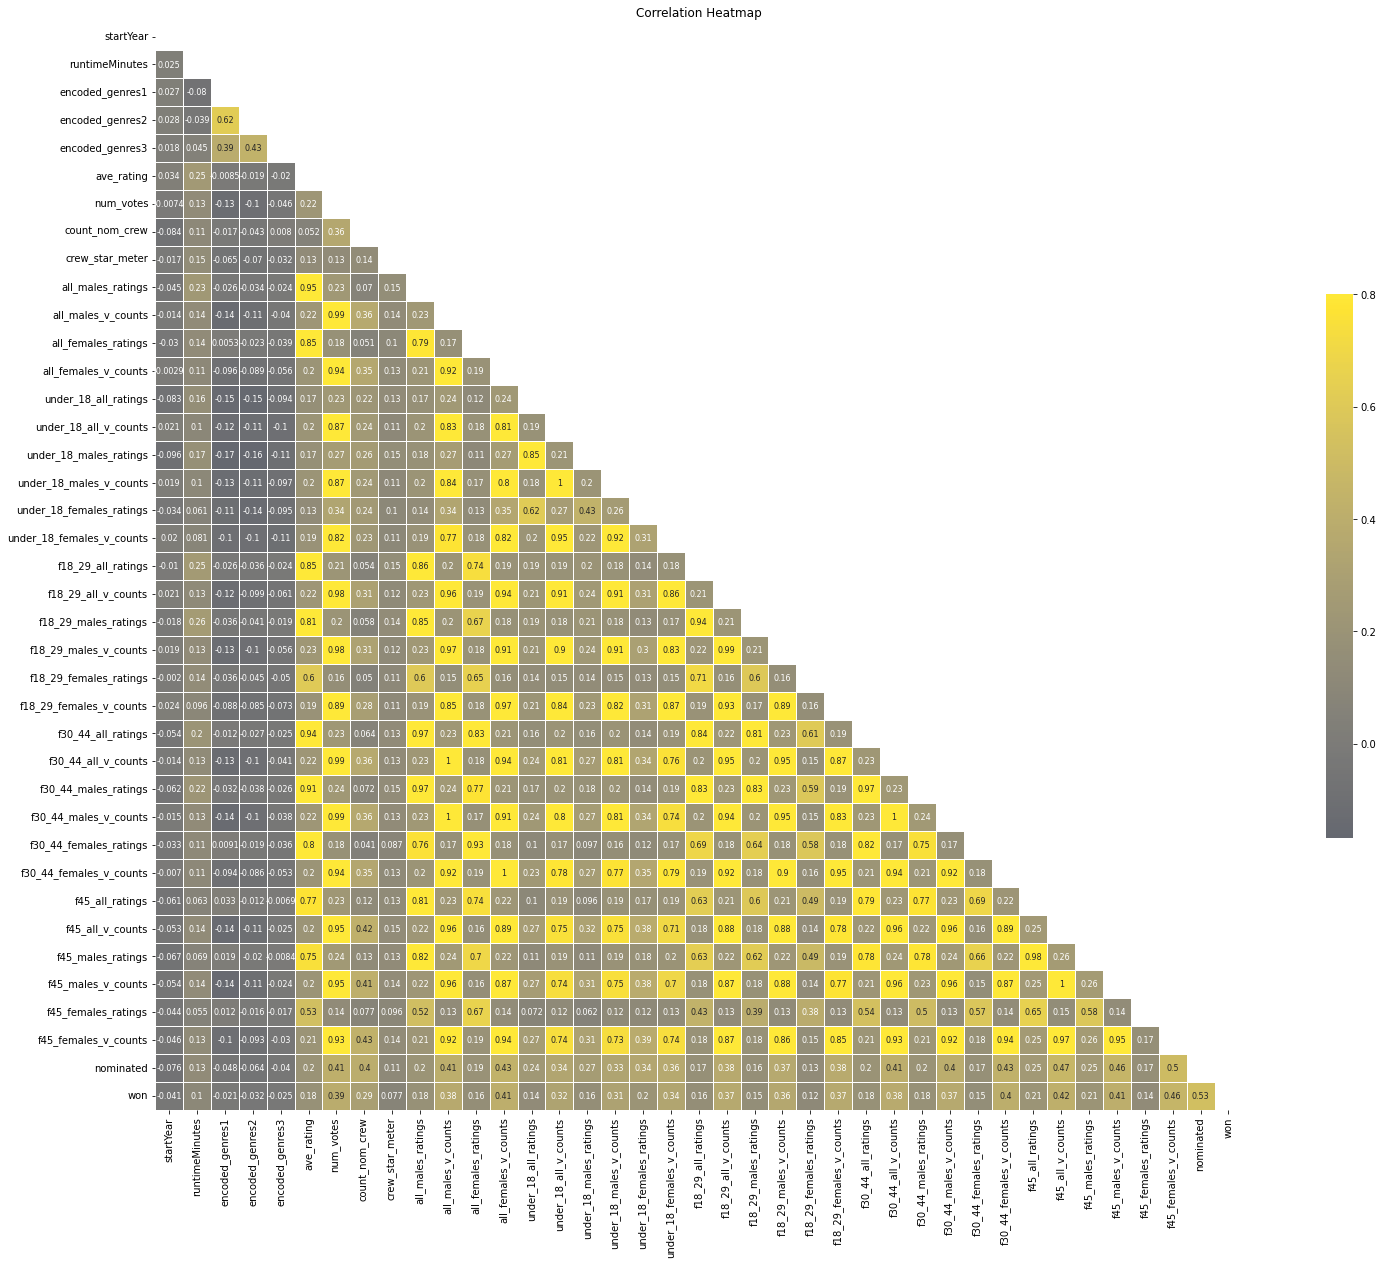

In [60]:
plot_heatmap(imdb_won)

In [54]:
imdb_nom = imdb_won.drop('won', axis=1)
imdb_nom.head()

,startYear,runtimeMinutes,encoded_genres1,encoded_genres2,encoded_genres3,ave_rating,num_votes,count_nom_crew,crew_star_meter,all_males_ratings,all_males_v_counts,all_females_ratings,all_females_v_counts,under_18_all_ratings,under_18_all_v_counts,under_18_males_ratings,under_18_males_v_counts,under_18_females_ratings,under_18_females_v_counts,f18_29_all_ratings,f18_29_all_v_counts,f18_29_males_ratings,f18_29_males_v_counts,f18_29_females_ratings,f18_29_females_v_counts,f30_44_all_ratings,f30_44_all_v_counts,f30_44_males_ratings,f30_44_males_v_counts,f30_44_females_ratings,f30_44_females_v_counts,f45_all_ratings,f45_all_v_counts,f45_males_ratings,f45_males_v_counts,f45_females_ratings,f45_females_v_counts,nominated
0,1981.00000,150.00000,0.00000,6.00000,8.00000,6.70000,1247.00000,0.00000,7.03008,6.60000,844.00000,7.20000,192.00000,6.00000,1.00000,0.00000,0.00000,6.00000,1.00000,5.40000,17.00000,5.30000,13.00000,5.80000,4.00000,6.60000,360.00000,6.50000,303.00000,7.20000,55.00000,6.70000,637.00000,6.70000,503.00000,7.20000,130.00000,0
1,1981.00000,90.00000,5.00000,20.00000,20.00000,6.40000,2073.00000,0.00000,7.00353,6.30000,1407.00000,6.80000,149.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.70000,140.00000,6.80000,110.00000,6.60000,24.00000,6.50000,866.00000,6.50000,765.00000,6.90000,85.00000,6.00000,500.00000,6.00000,455.00000,6.30000,34.00000,0
2,1981.00000,110.00000,8.00000,15.00000,27.00000,6.30000,8969.00000,1.00000,6.86382,6.20000,5711.00000,6.70000,1290.00000,8.00000,1.00000,8.00000,1.00000,0.00000,0.00000,5.90000,162.00000,5.80000,124.00000,6.10000,35.00000,6.00000,2377.00000,6.00000,1926.00000,6.10000,413.00000,6.40000,4319.00000,6.40000,3474.00000,7.10000,776.00000,0
3,1982.00000,76.00000,6.00000,8.00000,20.00000,7.30000,7113.00000,0.00000,7.69821,7.30000,4890.00000,7.10000,616.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,7.10000,474.00000,7.10000,382.00000,6.90000,78.00000,7.30000,3263.00000,7.30000,2825.00000,7.20000,390.00000,7.30000,1679.00000,7.30000,1517.00000,7.10000,126.00000,0
4,1983.00000,97.00000,8.00000,15.00000,20.00000,6.60000,27294.00000,1.00000,7.15918,6.60000,16451.00000,6.90000,4611.00000,8.00000,4.00000,8.00000,3.00000,8.00000,1.00000,6.80000,1327.00000,6.80000,852.00000,6.80000,428.00000,6.60000,10074.00000,6.50000,7481.00000,6.80000,2441.00000,6.60000,9212.00000,6.50000,7536.00000,7.00000,1539.00000,0


In [69]:
imdb_nom['nominated'].value_counts()

0    14293
1     1135
Name: nominated, dtype: int64

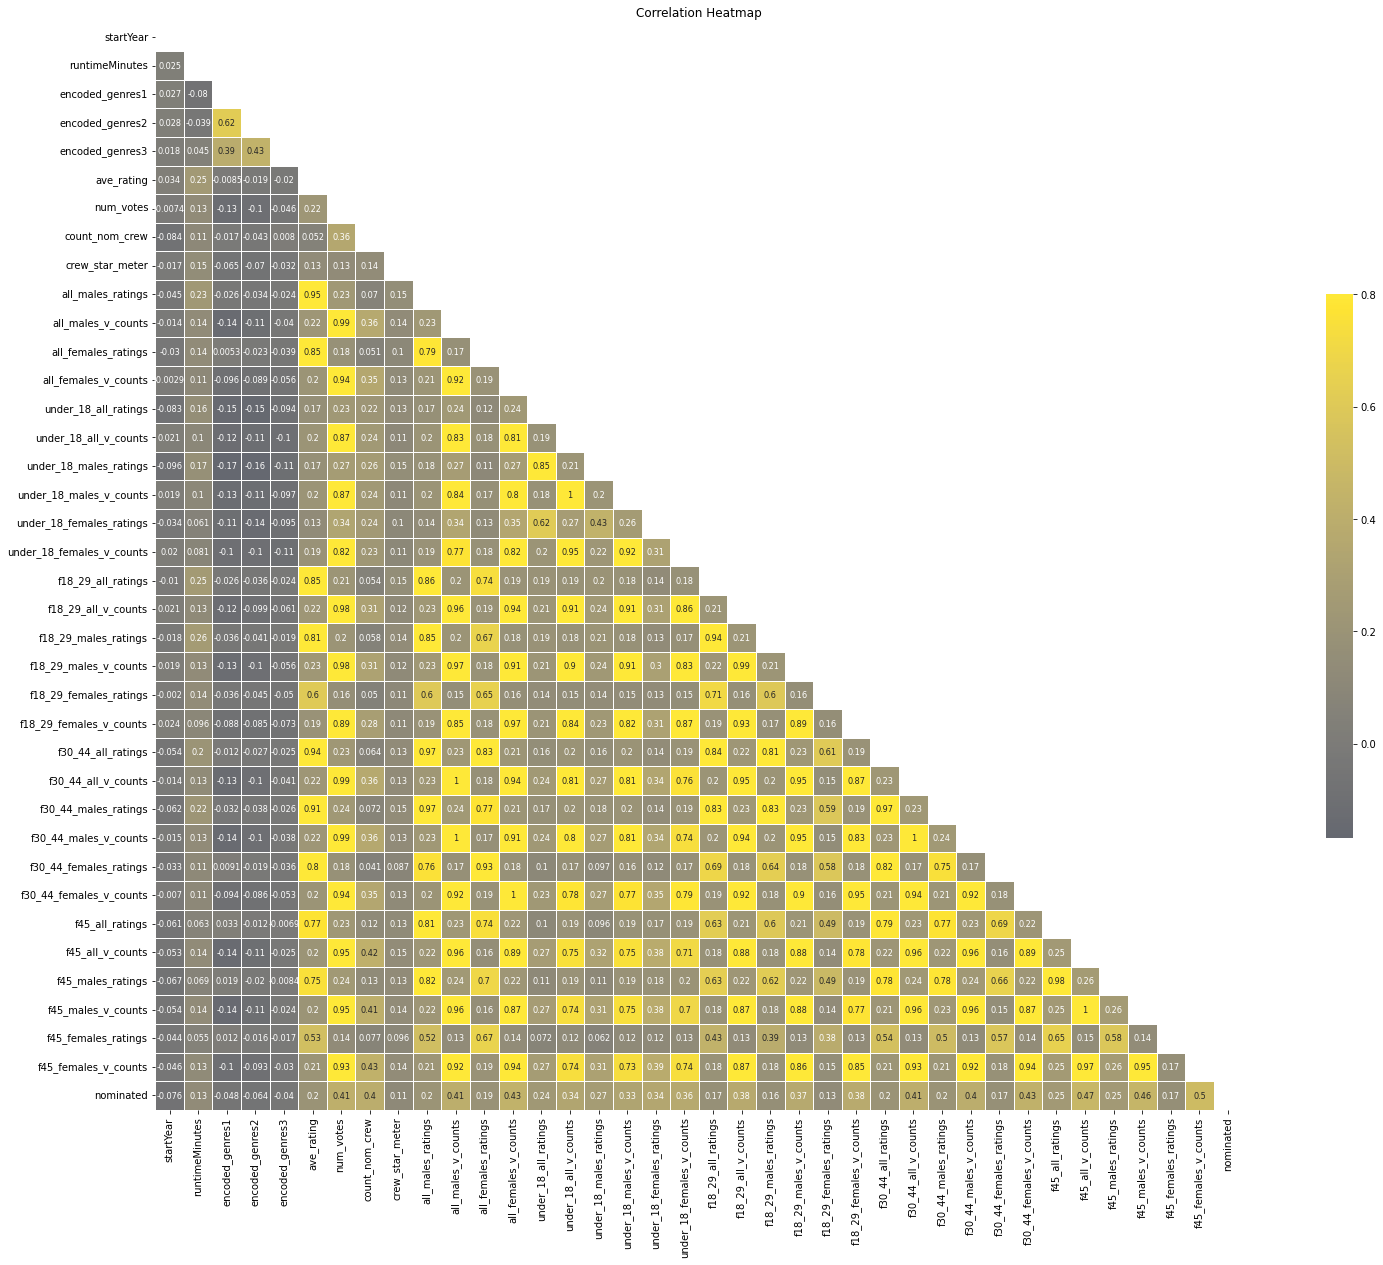

In [57]:
plot_heatmap(imdb_nom)

In [59]:
cols_num_rating = ['all_males_ratings', 'all_females_ratings',
 'under_18_all_ratings','under_18_males_ratings','under_18_females_ratings',
 'f18_29_all_ratings','f18_29_males_ratings','f18_29_females_ratings',
 'f30_44_all_ratings','f30_44_males_ratings','f30_44_females_ratings',
 'f45_all_ratings','f45_males_ratings','f45_females_ratings']

cols_u18_rating = ['under_18_males_ratings','under_18_females_ratings']
cols_u29_rating = ['f18_29_males_ratings','f18_29_females_ratings']
cols_u44_rating = ['f30_44_males_ratings','f30_44_females_ratings']
cols_f45_rating = ['f45_males_ratings','f45_females_ratings']
cols_agg_rating = ['all_males_ratings', 'all_females_ratings']

cols_main = ['startYear', 'runtimeMinutes', 'encoded_genres1', 'encoded_genres2', 'encoded_genres3', 'ave_rating', 'num_votes', 'count_nom_crew', 'crew_star_meter']

### Modeling on imdb full set (no feature engineering, no upsampling)

#### Split X_y, train_test

In [61]:
X = imdb_won.drop(['won'], axis=1)
y = imdb_won['won']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Model Pipeline & Name Definintion

In [105]:
model_pipeline = [dt_c]
model_names = ['Decision Tree_full']

#### Fitting - Decision Tree

In [116]:
dt_c = DecisionTreeClassifier(max_depth=3) 
dt_c.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

<BarContainer object of 38 artists>

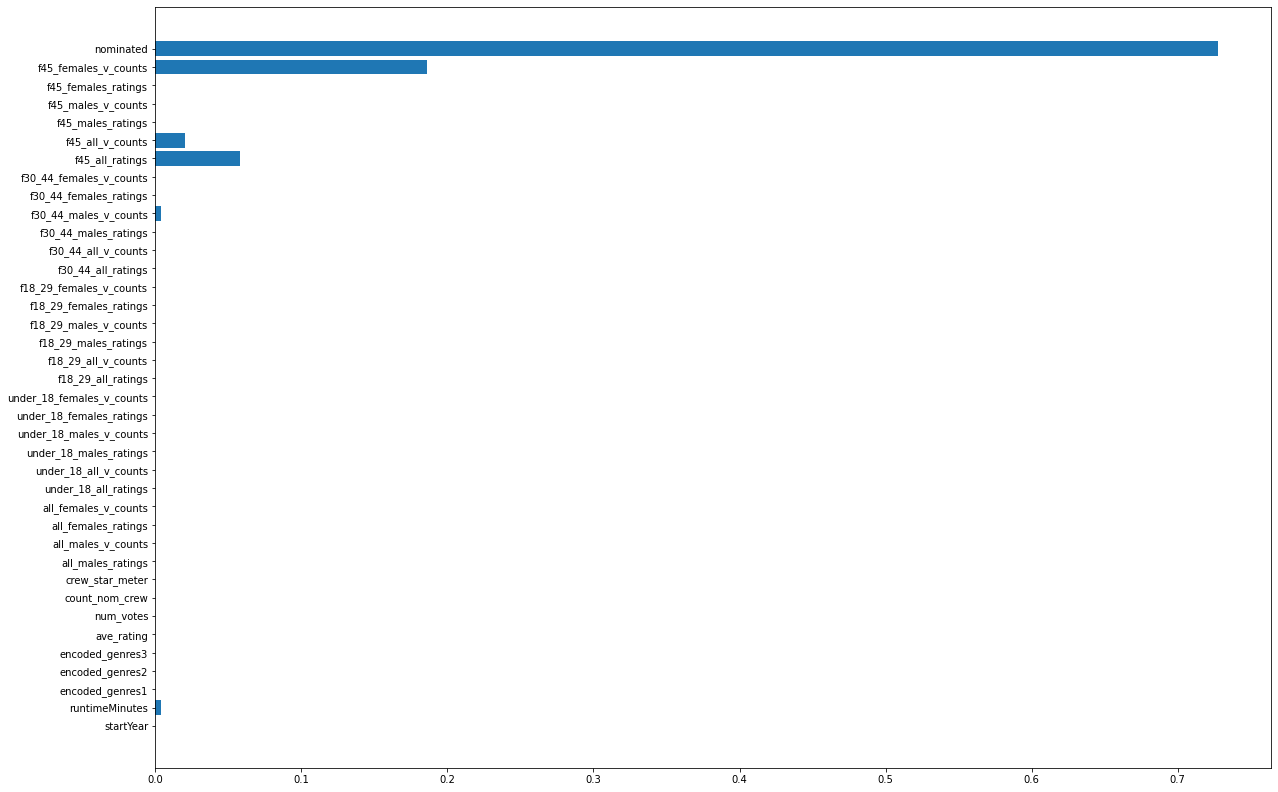

In [117]:
plt.figure(figsize=(20,14))
plt.barh(X.columns,dt_c.feature_importances_)

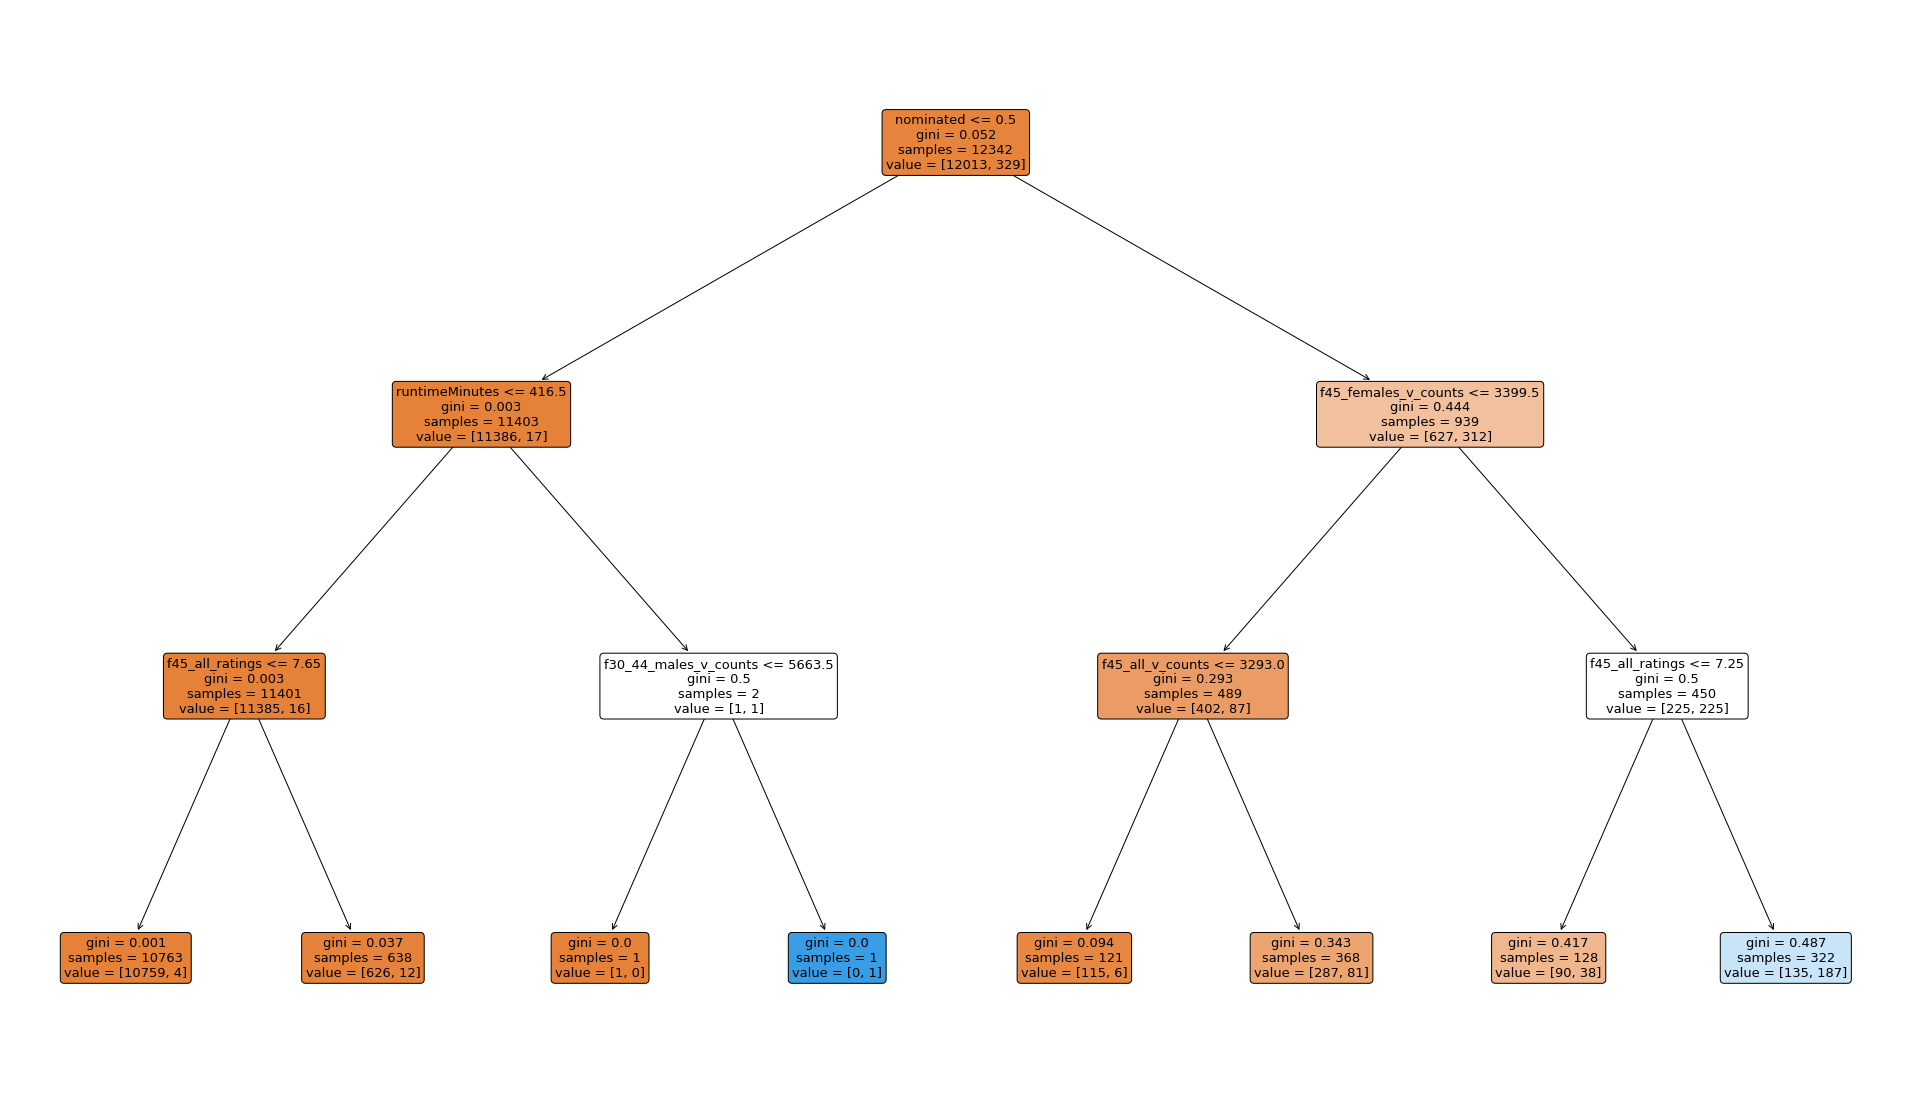

In [118]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (34,20))

plot_tree(dt_c,filled = True, rounded=True,feature_names=X.columns)
plt.show() 

TypeError: plot_confusion_matrix() missing 3 required positional arguments: 'y_test', 'model_pipeline', and 'model_names'

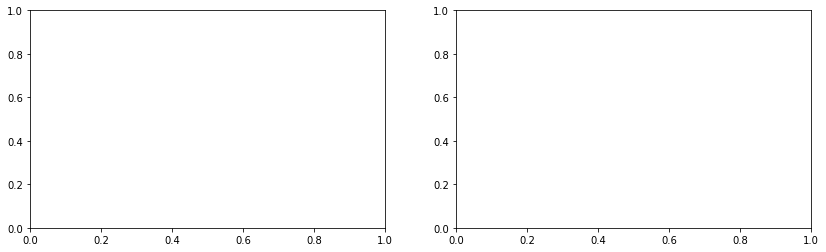

In [127]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))

plot_confusion_matrix(dt_c,X_train ,y_train)
plot_confusion_matrix(dt_c,X_test,y_test)


In [119]:
model_evaluation(X_train, X_test, y_train, y_test, 5, model_pipeline, model_names)

Decision Tree_full                     
                     Train Test Cross Val
0           Accuracy  0.98 0.98          
1          Precision  0.58 0.45          
2             Recall  0.57 0.48          
3      Ave of Scores                 0.98
4      Std of Scores                 0.00

In [103]:
param_grid_dt = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf' : [1, 2],
    # 'max_features': ['sqrt']
    ##'max_samples' : ['None', 0.5],
    ## 'bootstrap':[True,False]
    }

In [120]:
grid = GridSearchCV(
    dt_c,
    param_grid=param_grid_dt,
    cv=5, # number of cross-validation folds
    n_jobs=-1, # number of CPU cores to use (-1 means use all available cores)
    verbose=1
)

grid.fit(X_train, y_train)
best_params_dt = grid.best_params_


Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [121]:
best_params_dt

{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

### Pandas & SQL connection

In [10]:
from sqlalchemy import create_engine 
import os
import getpass
import pymysql.cursors

In [11]:
pw = os.getenv('mysql')
pw = getpass.getpass()

#### Func: convert_pd_df_tosql(fname,table_name,schema="imdb")

In [12]:
def convert_pd_df_tosql(fname,table_name,schema="imdb"):
    connection_string = 'mysql+pymysql://root:' + pw + '@127.0.0.1:3306/'
    engine = create_engine(connection_string)
    df = pd.read_csv(fname)
    df.to_sql(table_name,engine,schema,index=False, chunksize=5000)
    return "Created table"

#### Func: convert sql table to pandas dataframe

In [13]:
def convert_sqltable_to_pd_df(table_name, schema='imdb'):
    connection_string = 'mysql+pymysql://root:' + pw + '@127.0.0.1:3306/'
    engine = create_engine(connection_string)
    df = pd.read_sql_table(table_name, con = connection_string, schema='imdb')
    return df

### Draft - Testing Code Block

In [63]:
url = 'https://www.imdb.com/title/tt0017009/ratings?ref_=tturv_sa_3'
response = requests.get(url)
soup = bs4.BeautifulSoup(response.content, 'lxml')

In [64]:
table = soup.find('div', class_ = "allText")
table_user_rating = pd.read_html(str(table))
table_user_rating[1]

,Unnamed: 0,All Ages,<18,18-29,30-44,45+
0,All,7.3 12,-,-,6.8 5,8.5 6
1,Males,7.2 9,-,-,7.0 4,8.0 4
2,Females,7.5 3,-,-,6.0 1,9.0 2


In [70]:
import re
user_ratings = table_user_rating[1]
user_ratings = user_ratings.replace('-','0 0 0')
user_ratings = user_ratings.drop('Unnamed: 0', axis=1)
columns = ['all','under_18','f18_29','f30_44','f45']
user_ratings.columns = columns
user_ratings = user_ratings.applymap(lambda val: re.sub(r'(\d*),(\d*)', r'\1\2', val))
user_ratings

,all,under_18,f18_29,f30_44,f45
0,7.3 12,0 0 0,0 0 0,6.8 5,8.5 6
1,7.2 9,0 0 0,0 0 0,7.0 4,8.0 4
2,7.5 3,0 0 0,0 0 0,6.0 1,9.0 2


In [71]:
all_ages_ratings = rating_row(user_ratings, 'all')
under_18_ratings = rating_row(user_ratings, 'under_18')
f18_29_ratings = rating_row(user_ratings, 'f18_29')
f30_44_ratings = rating_row(user_ratings, 'f30_44')
f45_ratings = rating_row(user_ratings,'f45')

# all_ages_ratings
under_18_ratings

,all_ratings,all_v_counts,males_ratings,males_v_counts,females_ratings,females_v_counts,age_group
0,0,0,0,0,0,0,under_18


In [460]:
geo_ratings = table_user_rating[2]
list(geo_ratings.loc[0,:])
geo_ratings

,Top 1000 Voters,US Users,Non-US Users
0,7.0 1,6.8 14,4.6 13


In [640]:
all_ages_ratings = user_ratings['all'].str.split(' ', expand=True).rename(columns={0:'ratings', 1:'drop', 2:'v_counts'}, index={0:'all', 1:'males', 2:'females'})
all_ages_ratings.drop('drop',axis=1, inplace=True)

all_ages_ratings = all_ages_ratings.stack()
all_ages_ratings.index = all_ages_ratings.index.map('{0[0]}_{0[1]}'.format)
all_ages_ratings = all_ages_ratings.to_frame().T

all_ages_ratings['age_group'] = 'all'

all_ages_ratings

,all_ratings,all_v_counts,males_ratings,males_v_counts,females_ratings,females_v_counts,age_group
0,5.4,2097,5.3,1458,5.6,161,all


In [69]:
# i = 'tt0000008'
under_18_ratings = user_ratings['under_18'].str.split(' ', expand=True).rename(columns={0:'ratings', 1:'drop', 2:'v_counts'}, index={0:'all', 1:'males', 2:'females'}).fillna(0)
# under_18_ratings.drop('drop',axis=1, inplace=True)

# under_18_ratings = under_18_ratings.stack()
# under_18_ratings.index = under_18_ratings.index.map('{0[0]}_{0[1]}'.format)
# under_18_ratings = under_18_ratings.to_frame().T.fillna(0)
# under_18_ratings['age_group'] = 'under_18'

under_18_ratings


,ratings,drop
all,0,0
males,0,0
females,0,0


In [607]:
f18_29_ratings = user_ratings['f18_29'].str.split(' ', expand=True).rename(columns={0:'ratings', 1:'drop', 2:'v_counts'}, index={0:'all', 1:'males', 2:'females'})
f18_29_ratings.drop('drop',axis=1, inplace=True)

f18_29_ratings = f18_29_ratings.stack()
f18_29_ratings.index = f18_29_ratings.index.map('{0[0]}_{0[1]}'.format)
f18_29_ratings = f18_29_ratings.to_frame().T.fillna(0)
f18_29_ratings['age_group'] = 'f18_29'
f18_29_ratings

,all_ratings,all_v_counts,males_ratings,males_v_counts,females_ratings,females_v_counts,age_group
0,5.5,271,5.5,235,5.5,31,f18_29


#### Collecting: scraping for production house

In [71]:
url_prod = 'https://www.the-numbers.com/movies/production-companies/#production_companies_overview=od1'

res_prod = requests.get(url_prod)
soup_prod = bs4.BeautifulSoup(res_prod.content, 'lxml')
soup_prod

<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>403 Forbidden</title>
</head><body>
<h1>Forbidden</h1>
<p>You don't have permission to access /movies/production-companies/
on this server.</p>
</body></html>